In [1]:
library(Hmisc)
library(usdm)
library(mgcv)
library(RColorBrewer)
library(classInt)
library(rgdal)

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units

Loading required package: sp
Loading required package: raster

Attaching package: ‘raster’

The following objects are masked from ‘package:Hmisc’:

    mask, zoom

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:usdm’:

    Variogram

The following object is masked from ‘package:raster’:

    getData

This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.
Loading required package: spData
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source'))`
rgdal: version: 1.2-18, (SVN revision 718)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL

In [2]:
DATA_DIR <- "/Users/dongmeichen/GitHub/SDM/data/Xy_random_split_data"

In [3]:
OUT_DIR <- "/Users/dongmeichen/Documents/beetle/output/variable_selection"
setwd(OUT_DIR)

In [4]:
merge.files <- function(set=c('train', 'valid', 'test')) {
  cat(sprintf('Merging %s data...\n', set))
  all.files <- list.files(DATA_DIR)
  X.files <- sort(all.files[grepl(paste('X', set, sep='_'), all.files)])
  y.files <- sort(all.files[grepl(paste('y', set, sep='_'), all.files)])
  X <- read.csv(paste(DATA_DIR, X.files[1], sep='/'))
  y <- read.csv(paste(DATA_DIR, y.files[1], sep='/'))
  colnames(y) <- 'btl_t'
  data <- cbind(y, X)
  if (length(X.files) > 1) {
    for (i in 2:length(X.files)) {
      next.X <- read.csv(paste(DATA_DIR, X.files[i], sep='/'))
      next.y <- read.csv(paste(DATA_DIR, y.files[i], sep='/'))
      colnames(next.y) <- 'btl_t'
      next.data <- cbind(next.y, next.X)
      data <- rbind(data, next.data)
    }
  }
  data
}

In [5]:
ptm <- proc.time()
train <- merge.files('train')
proc.time() - ptm

Merging train data...


   user  system elapsed 
107.423   7.303 117.468 

In [6]:
ptm <- proc.time()
test <- merge.files('test')
proc.time() - ptm

Merging test data...


   user  system elapsed 
 10.562   0.931  12.065 

In [7]:
head(train)

btl_t,x,y,lon,lat,etopo1,btl_t1,btl_t2,vgt,age,⋯,minT,cv.gsp,wd,vpd,mi,cwd,pt.coef,x.new,y.new,xy
0,-390000,-2040000,-104.0535,31.46420,994,0,0,0,0,⋯,-9.074840,7.123426,-37.55907,409401.4,0.3873256,870.9352,0.3262042,27,1,x27y1
0,-380000,-2040000,-103.9497,31.46874,948,0,0,0,0,⋯,-9.013754,7.248015,-34.44114,414756.6,0.4008041,870.7953,0.3322253,27,1,x27y1
0,-370000,-2040000,-103.8458,31.47316,944,0,0,0,0,⋯,-8.951233,6.764740,-40.68843,416408.0,0.4024214,872.5840,0.3339312,27,1,x27y1
0,-360000,-2040000,-103.7420,31.47746,889,0,0,0,0,⋯,-8.760722,7.184930,-38.31944,424007.8,0.4002201,875.0765,0.3331008,27,1,x27y1
0,-350000,-2040000,-103.6382,31.48165,827,0,0,0,0,⋯,-8.512301,7.722649,-53.42512,435018.2,0.3848327,882.3765,0.3242965,27,1,x27y1
0,-340000,-2040000,-103.5343,31.48571,801,0,0,0,0,⋯,-8.272153,8.207361,-62.27799,442159.1,0.3732446,887.5115,0.3165958,27,1,x27y1


In [8]:
names(train)

[1] "btl_t"       "x"           "y"           "lon"         "lat"        
 [6] "etopo1"      "btl_t1"      "btl_t2"      "vgt"         "age"        
[11] "density"     "sum9_t1"     "sum9_t2"     "year"        "sum9_diff"  
[16] "JanTmin"     "MarTmin"     "TMarAug"     "summerTmean" "AugTmean"   
[21] "AugTmax"     "PMarAug"     "summerP0"    "OctTmin"     "fallTmean"  
[26] "Tmin"        "Tmean"       "Tvar"        "TOctSep"     "summerP1"   
[31] "summerP2"    "Pmean"       "POctSep"     "PcumOctSep"  "PPT"        
[36] "Lcs"         "maxAugT"     "summerT40"   "OptTsum"     "AugMaxT"    
[41] "maxT"        "Ecs"         "Ncs"         "Acs"         "drop0"      
[46] "drop5"       "drop10"      "drop15"      "drop20"      "drop20plus" 
[51] "max.drop"    "ddAugJul"    "ddAugJun"    "Oct20"       "Oct30"      
[56] "Oct40"       "Jan20"       "Jan30"       "Jan40"       "Mar20"      
[61] "Mar30"       "Mar40"       "winter20"    "winter30"    "winter40"   
[66] "OctMin"      "JanMin"      "MarMin"      "winterMin"   "minT"       
[71] "cv.gsp"      "wd"          "vpd"         "mi"          "cwd"        
[76] "pt.coef"     "x.new"       "y.new"       "xy"

In [9]:
cold0 <- c('Jan20','Mar20','Acs','max.drop')
cold <- c('JanTmin', 'MarTmin', 'OctTmin', 'Tmin', 'OctMin', 'JanMin', 'MarMin', 'winterMin', 'minT') 
season <- c('TMarAug', 'fallTmean', 'Tmean', 'Tvar', 'TOctSep', 'ddAugJul', 'ddAugJun')
summerT <- c('summerTmean', 'AugTmean', 'AugTmax', 'maxAugT', 'OptTsum', 'AugMaxT', 'maxT')
drought <- c('PMarAug', 'summerP0', 'summerP1', 'summerP2', 'Pmean', 'POctSep', 'PcumOctSep', 'PPT')
drought1 <- c('wd', 'vpd', 'mi', 'cwd')
vars <- c(cold0, cold, season, summerT, drought, drought1)

Warning message in bxp(structure(list(stats = structure(c(0, 0, 0, 3, 7, 0, 0, 0, :
“some notches went outside hinges ('box'): maybe set notch=FALSE”

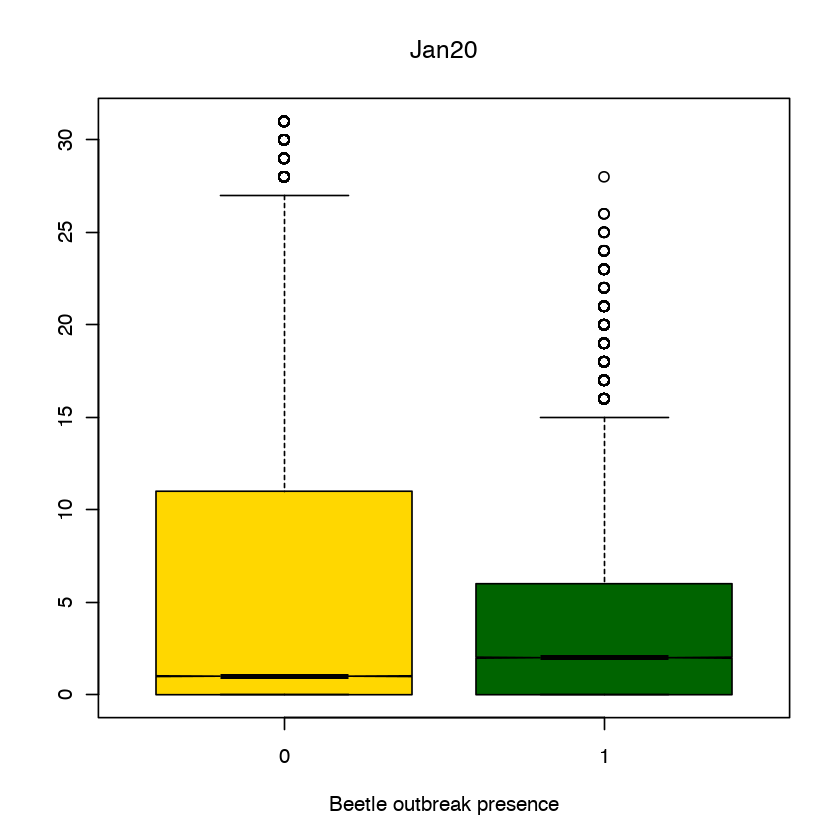

Warning message in bxp(structure(list(stats = structure(c(0, 0, 0, 6.66666666666667, :
“some notches went outside hinges ('box'): maybe set notch=FALSE”

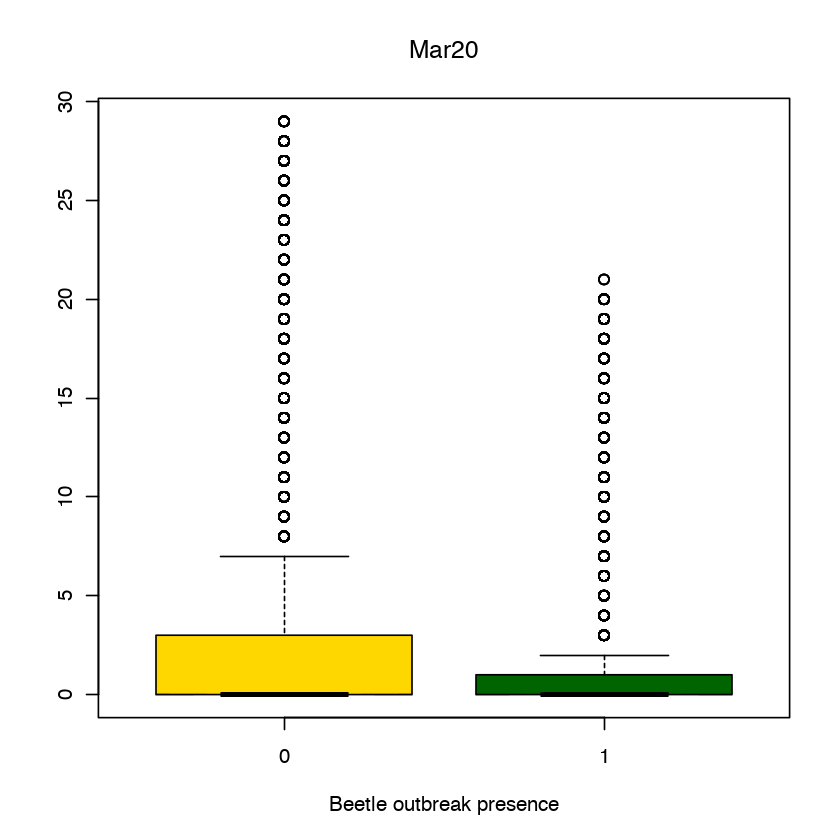

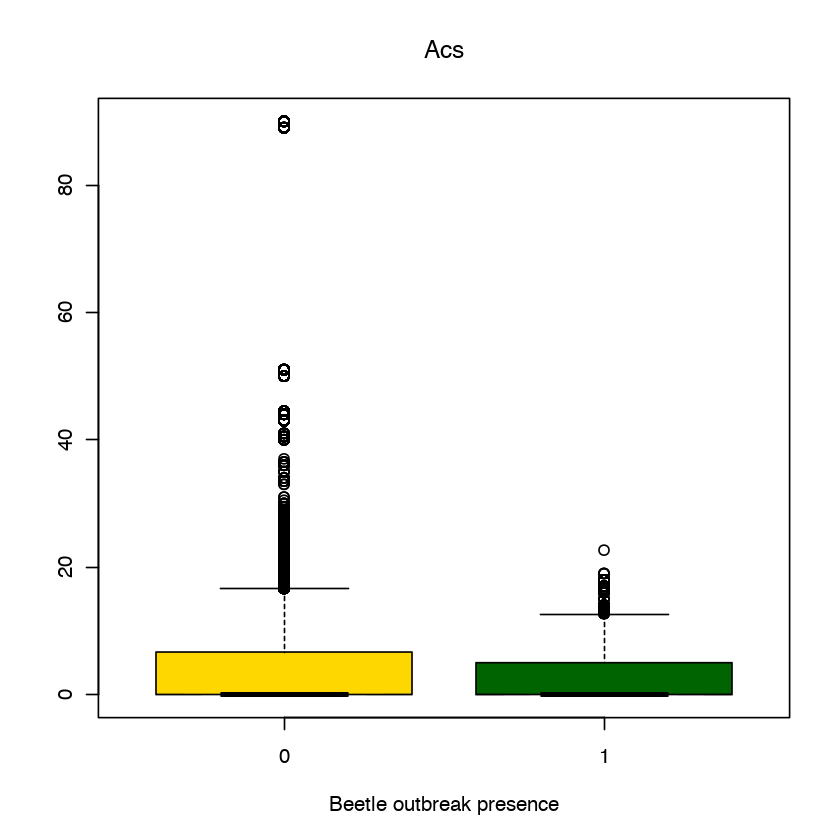

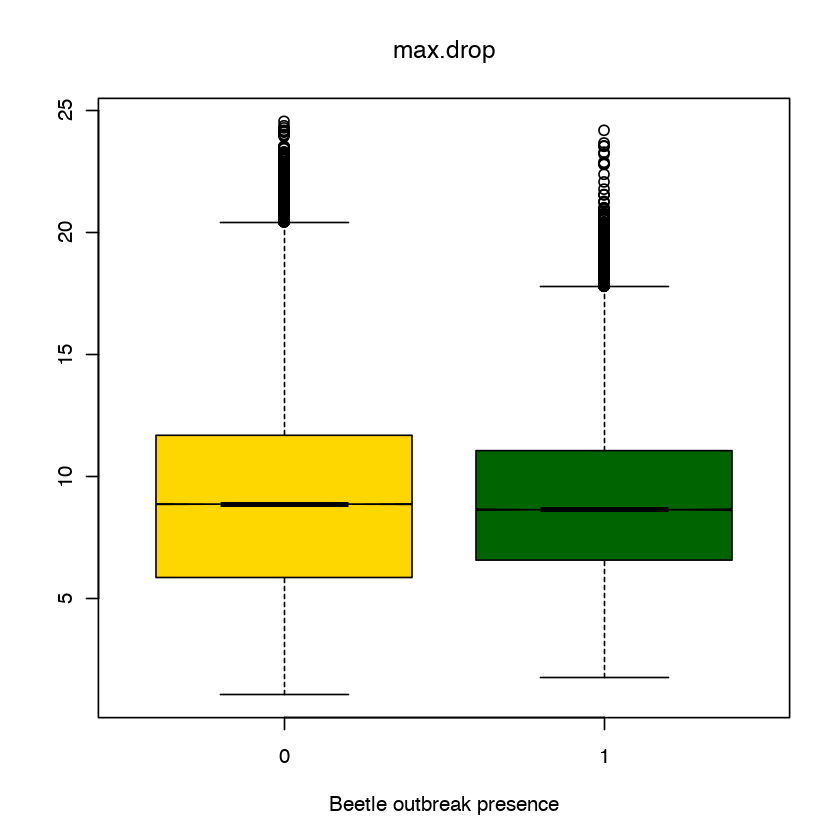

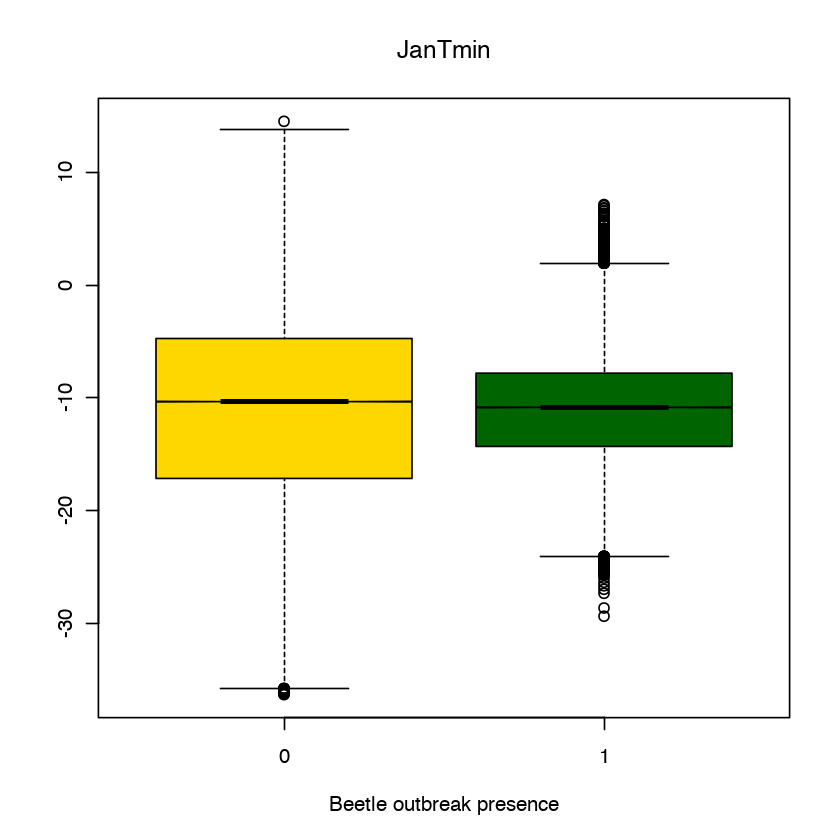

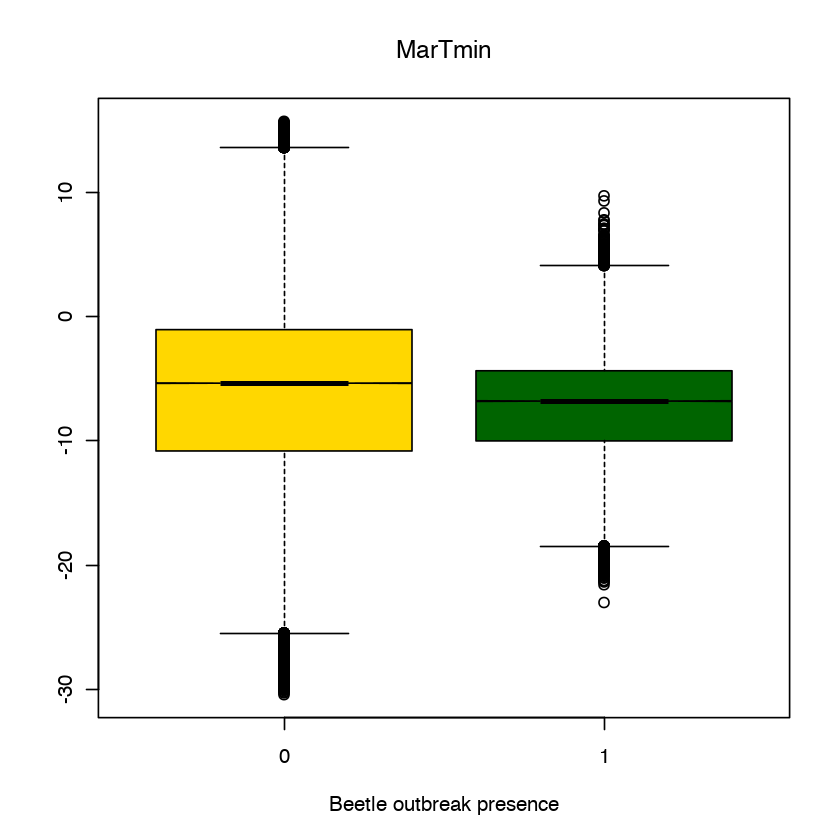

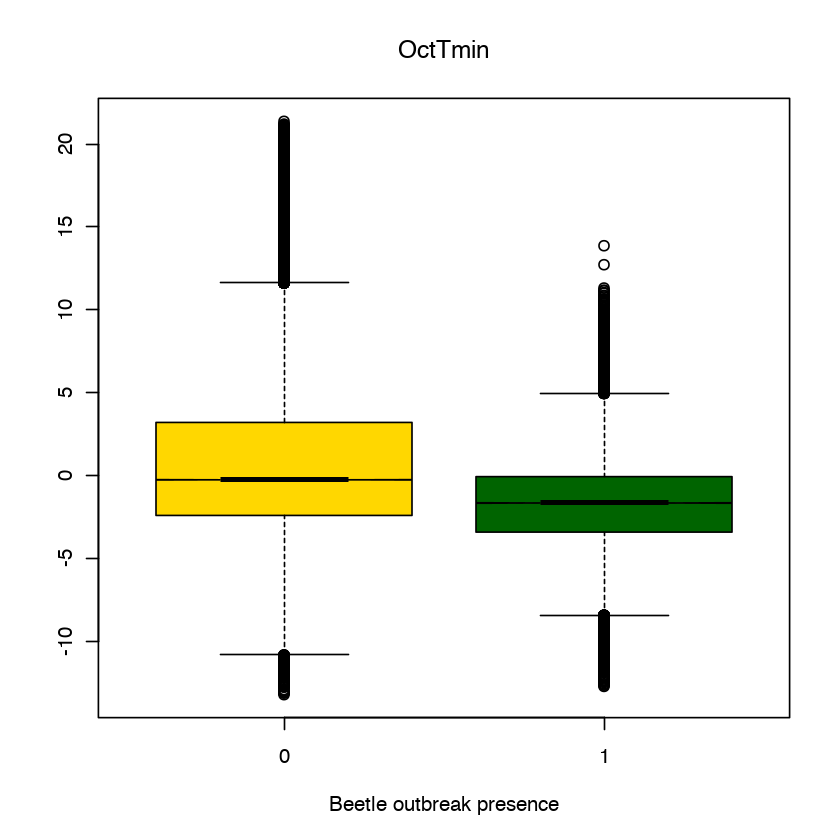

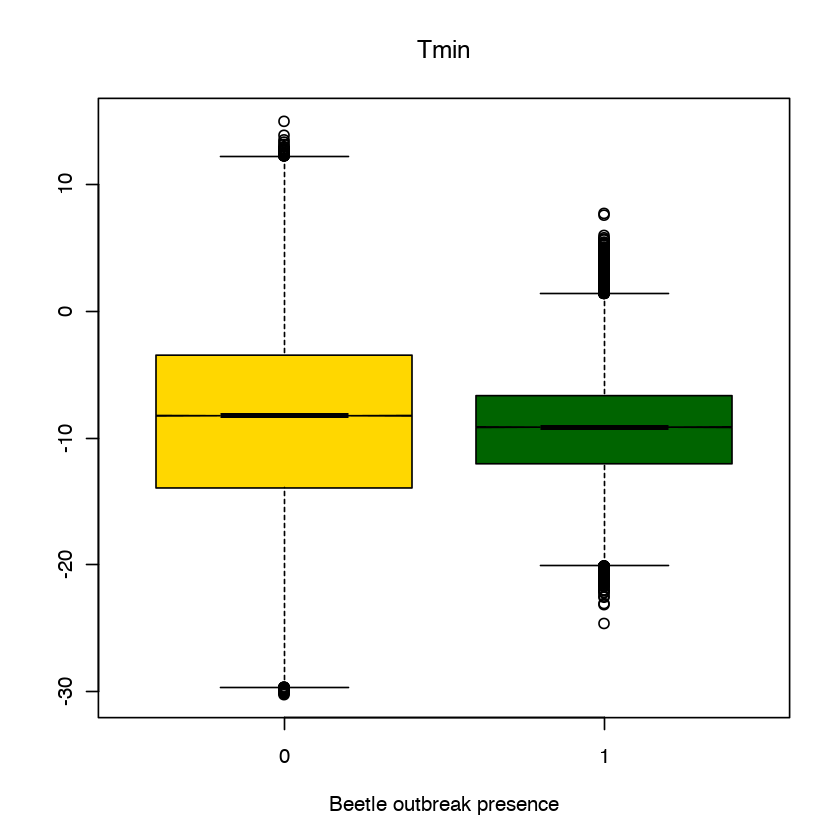

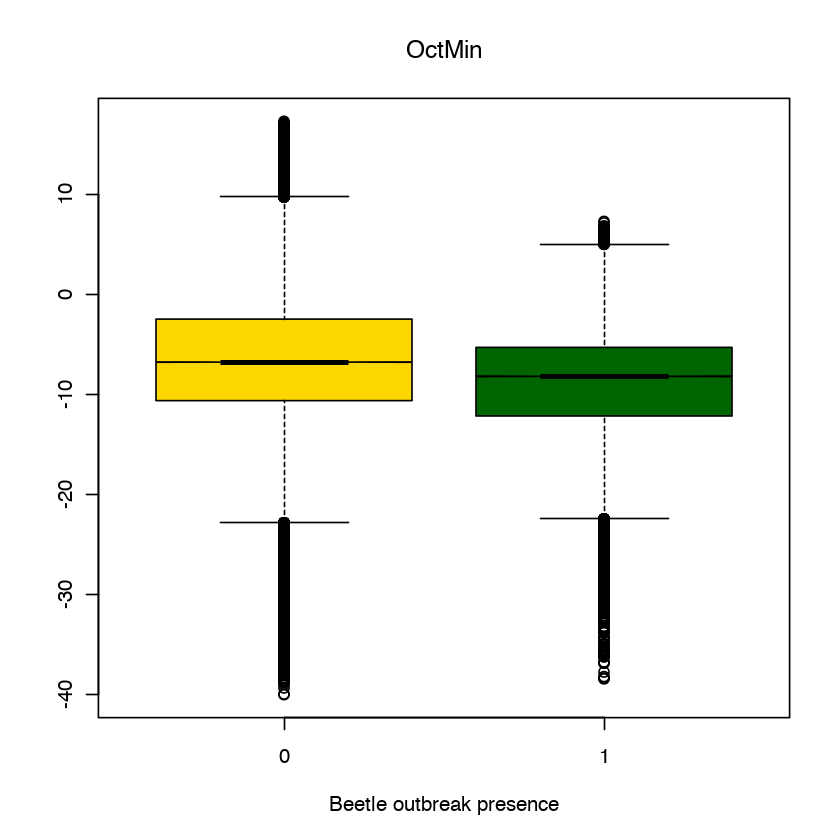

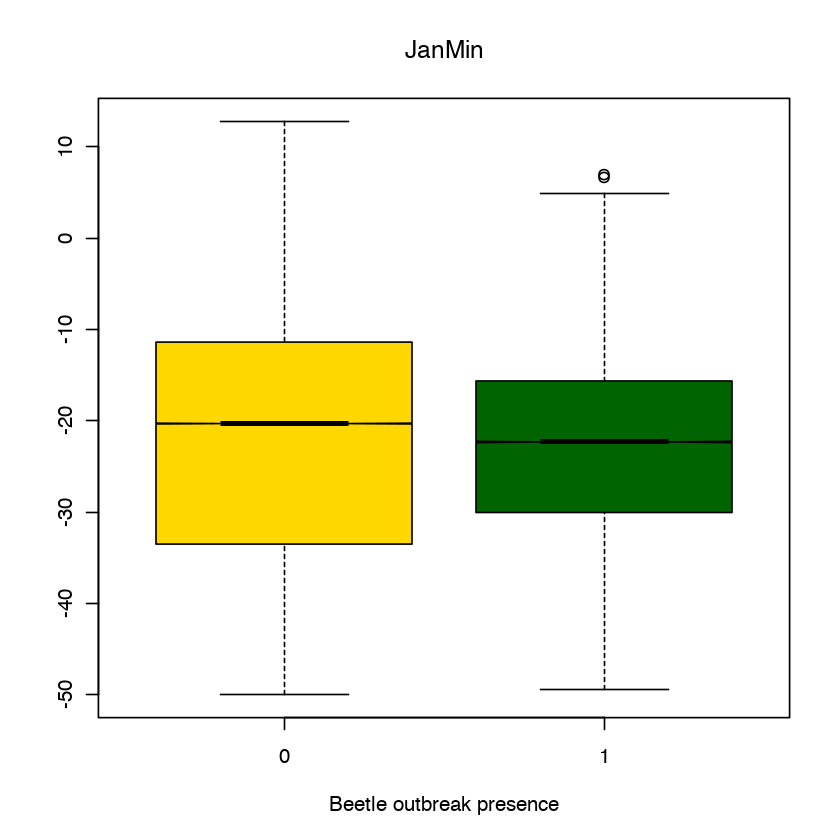

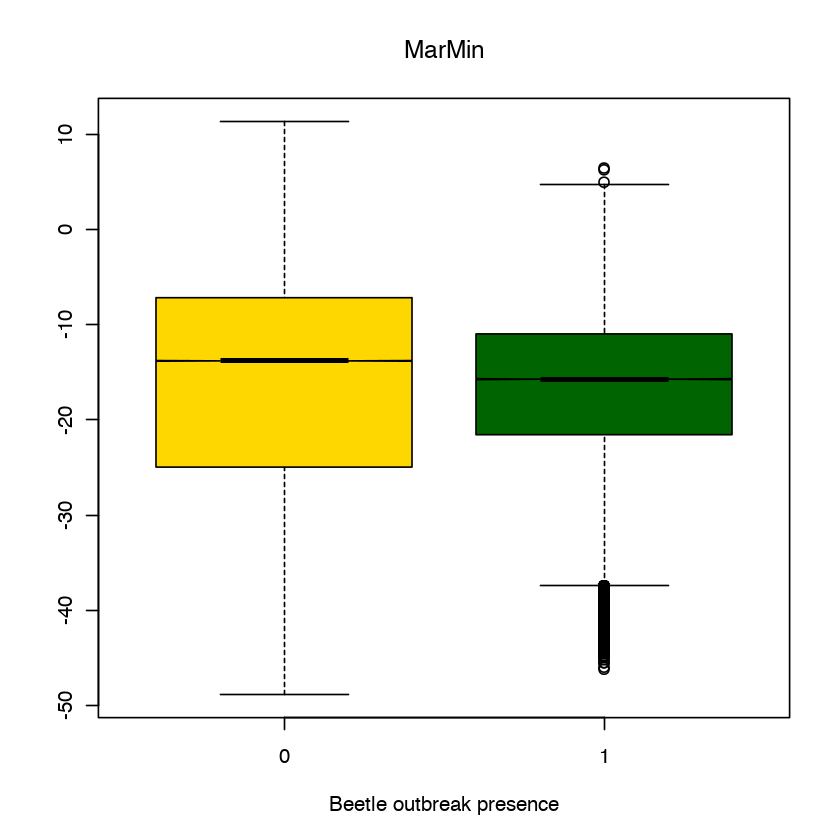

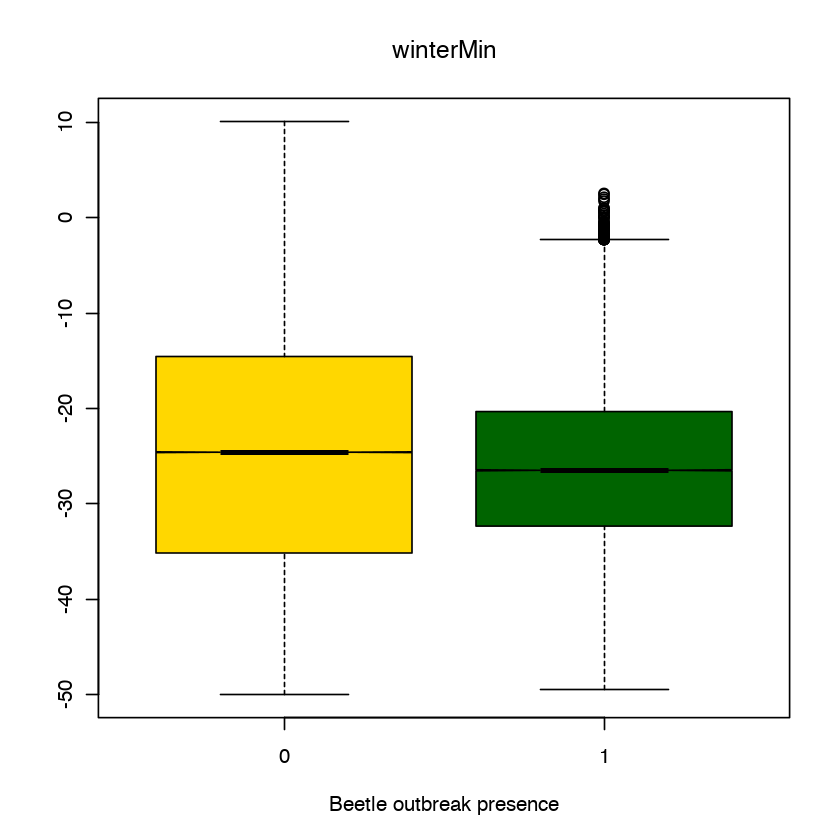

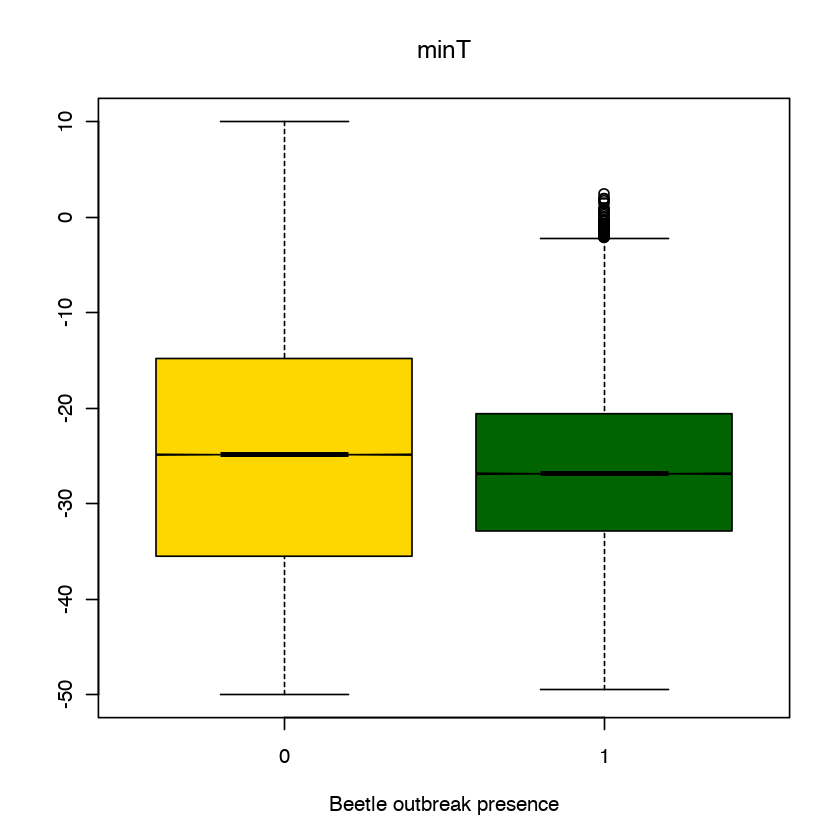

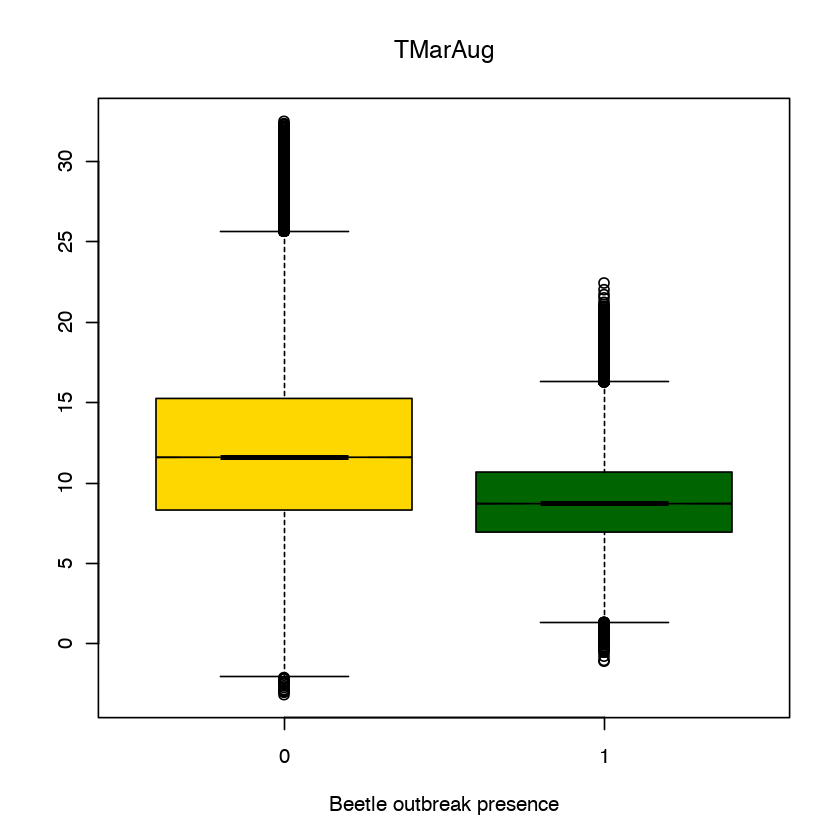

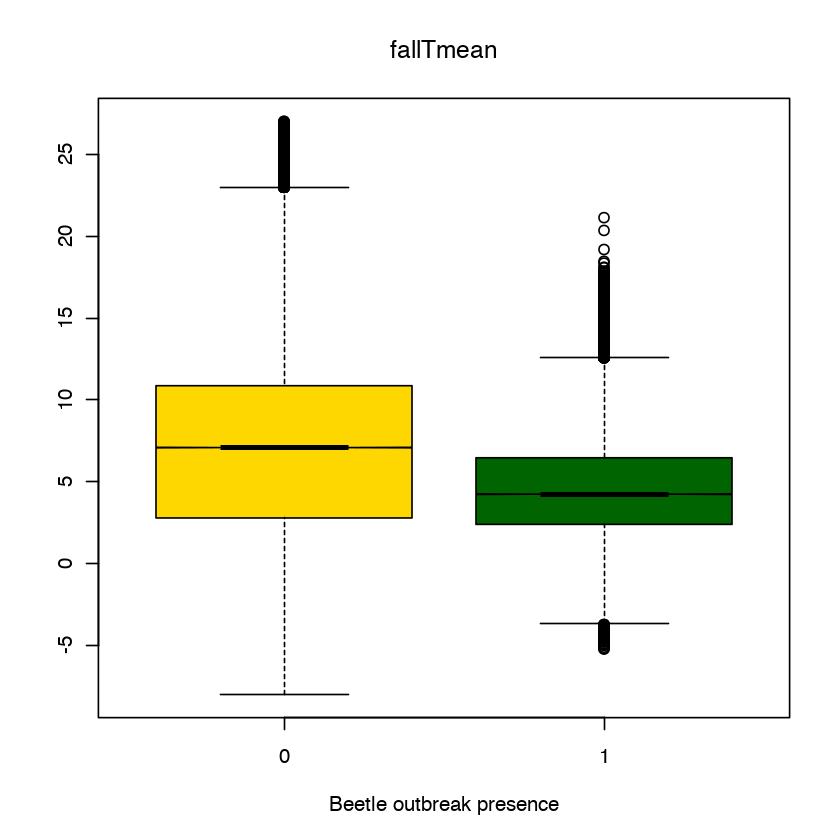

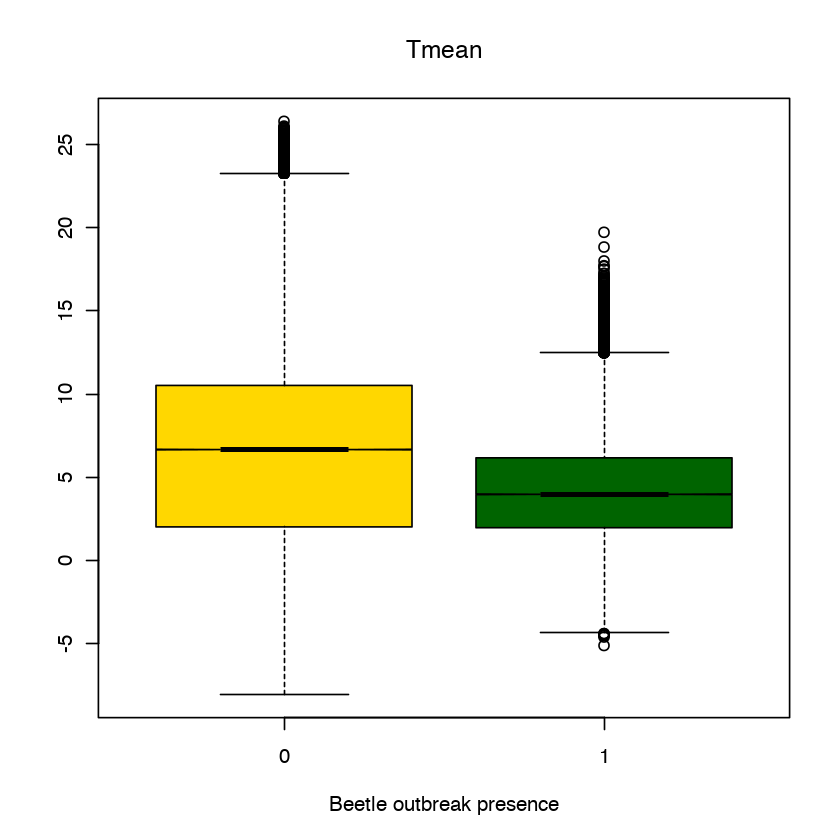

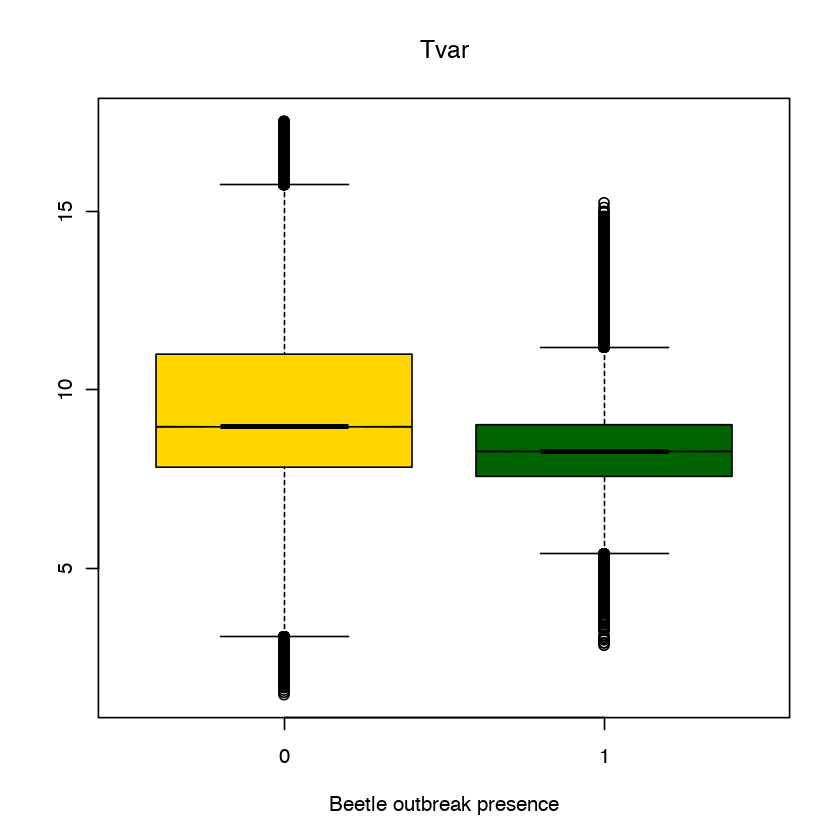

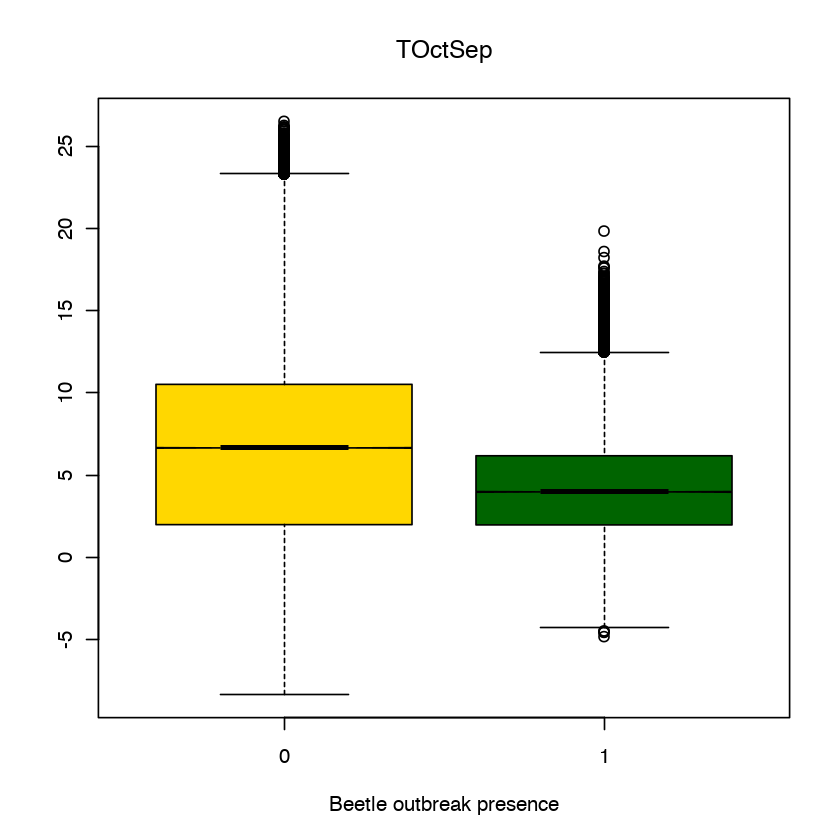

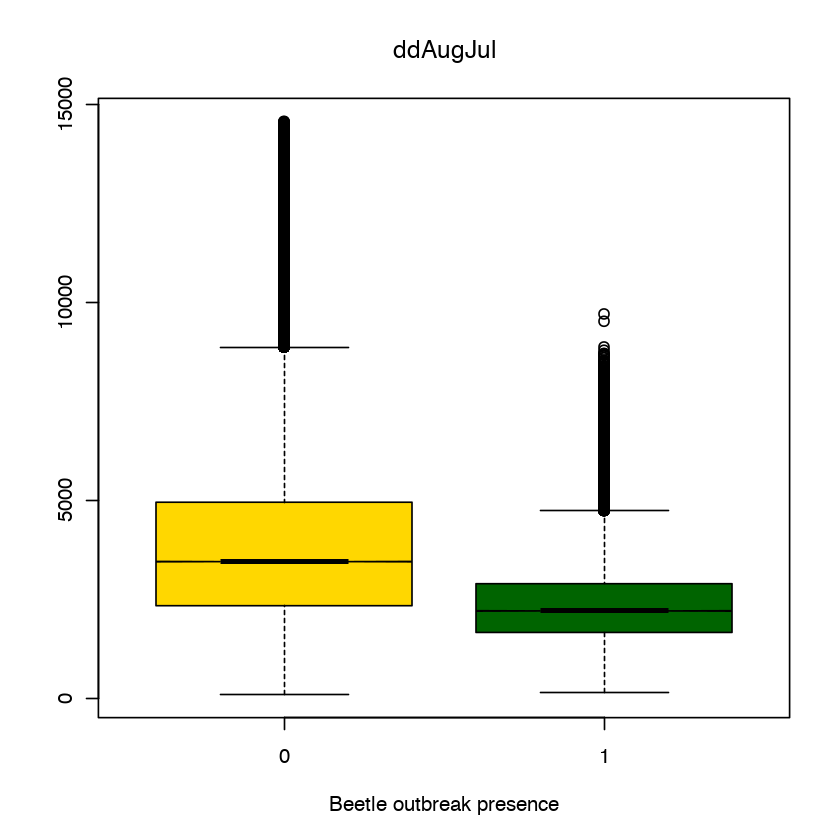

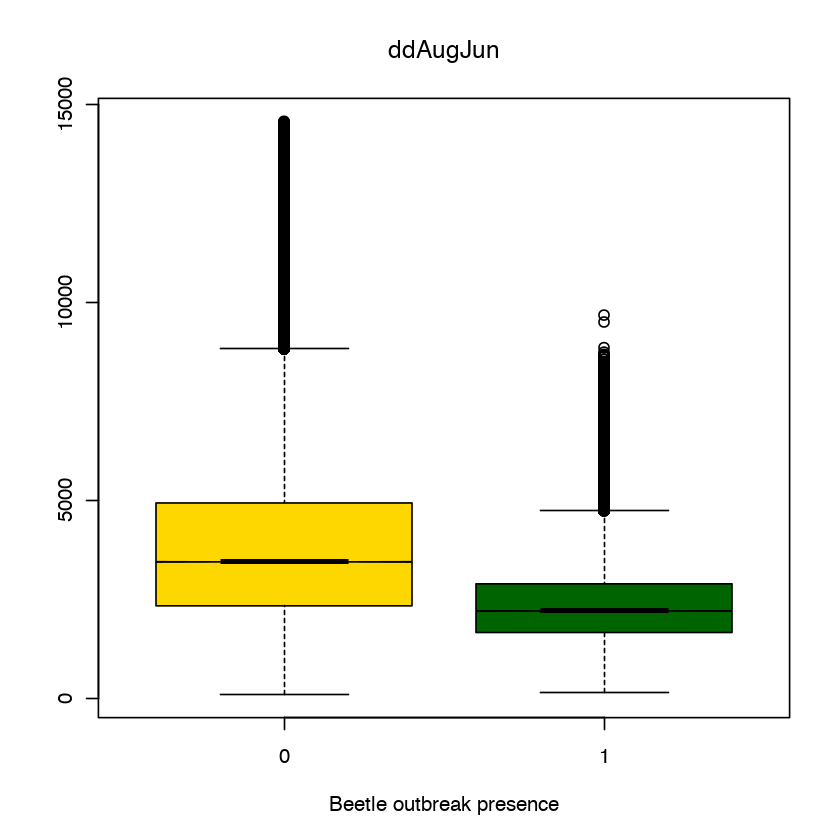

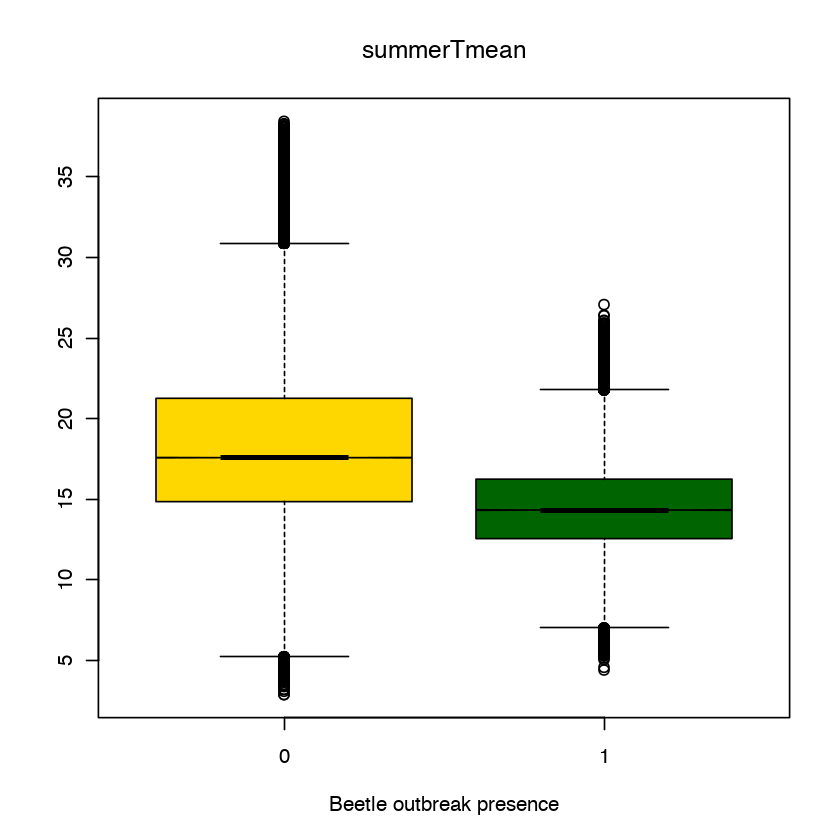

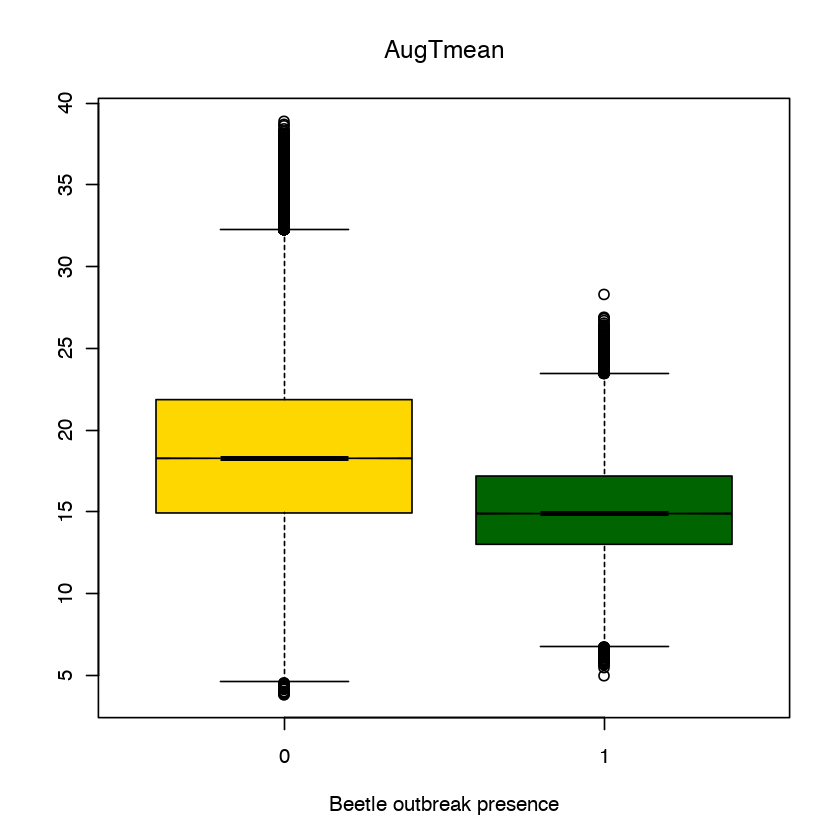

Warning message in bxp(structure(list(stats = structure(c(14, 24, 31, 31, 31, 5, :
“some notches went outside hinges ('box'): maybe set notch=FALSE”

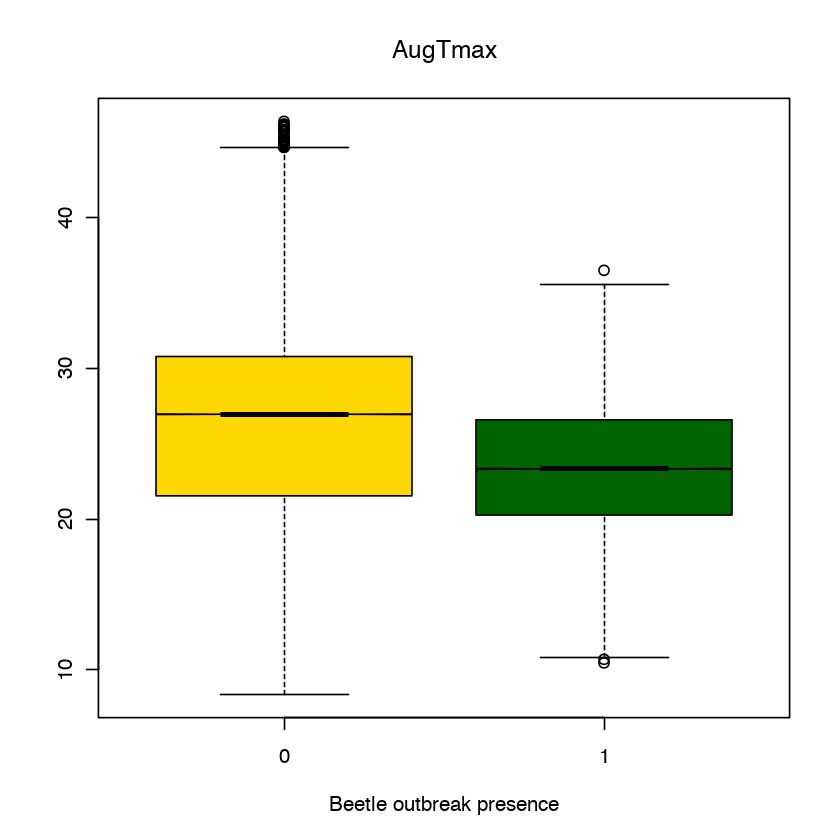

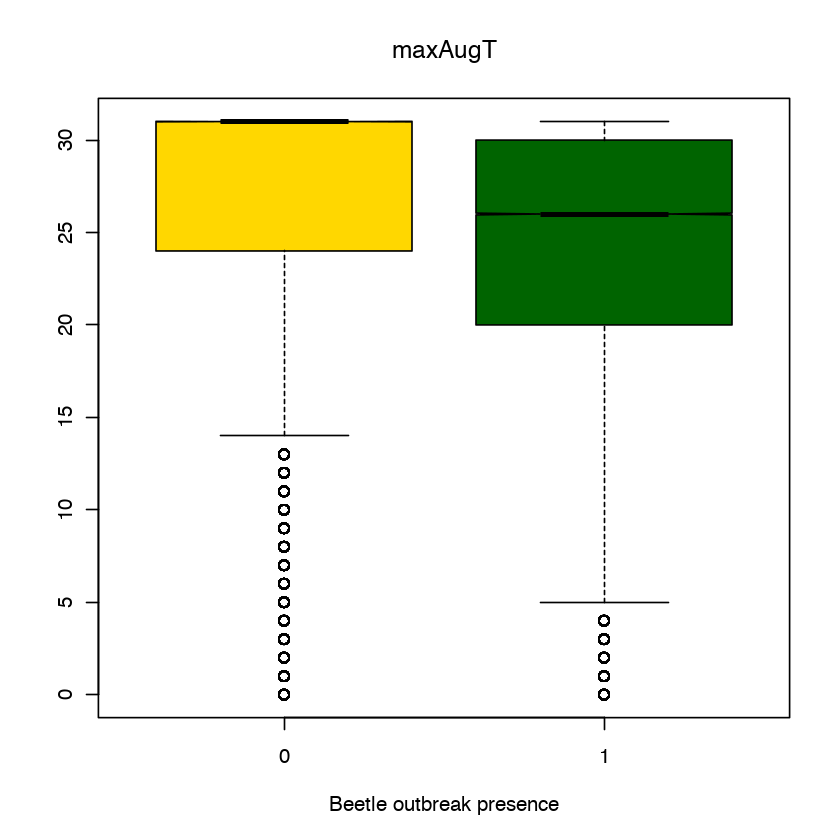

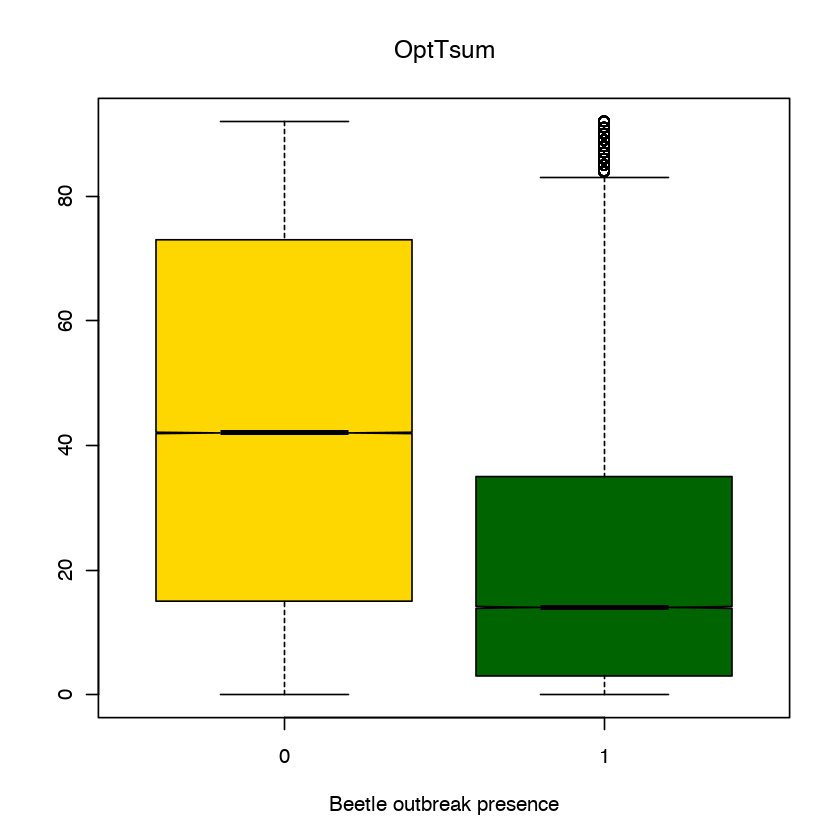

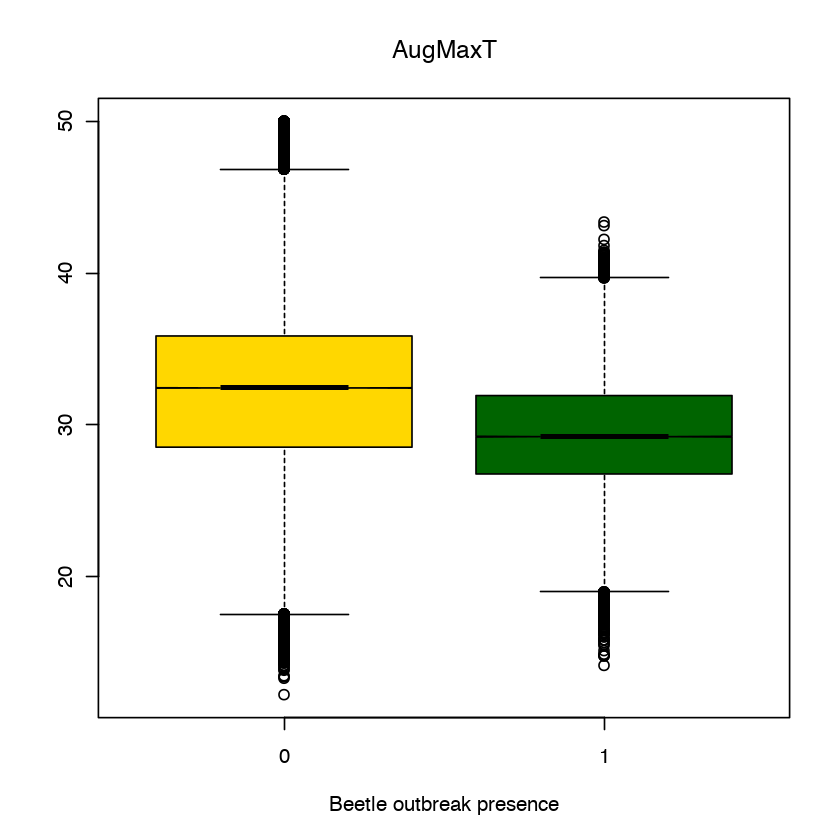

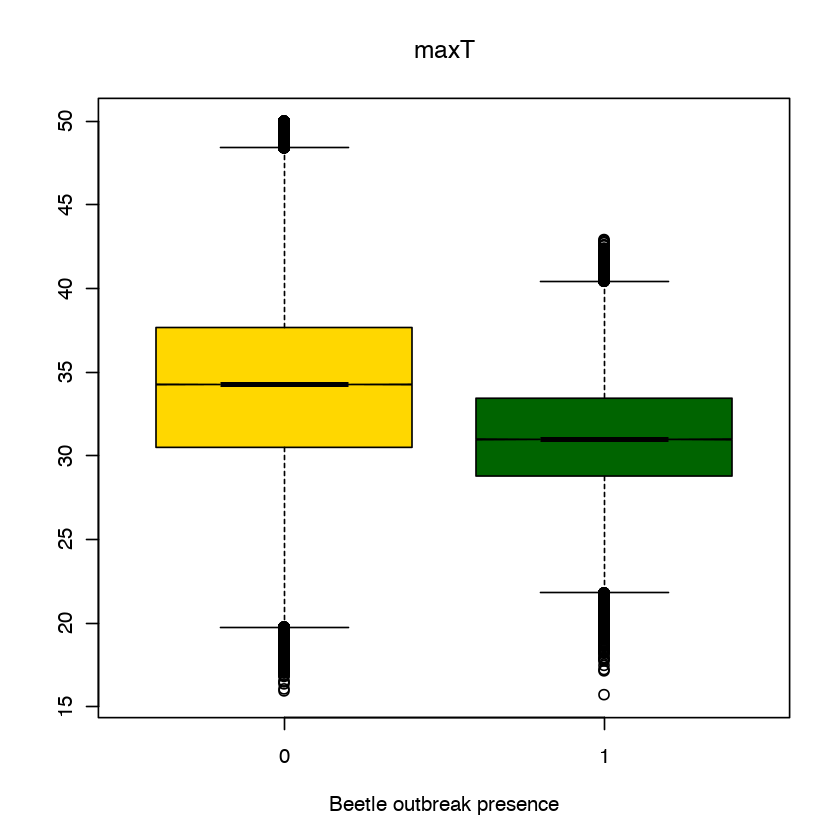

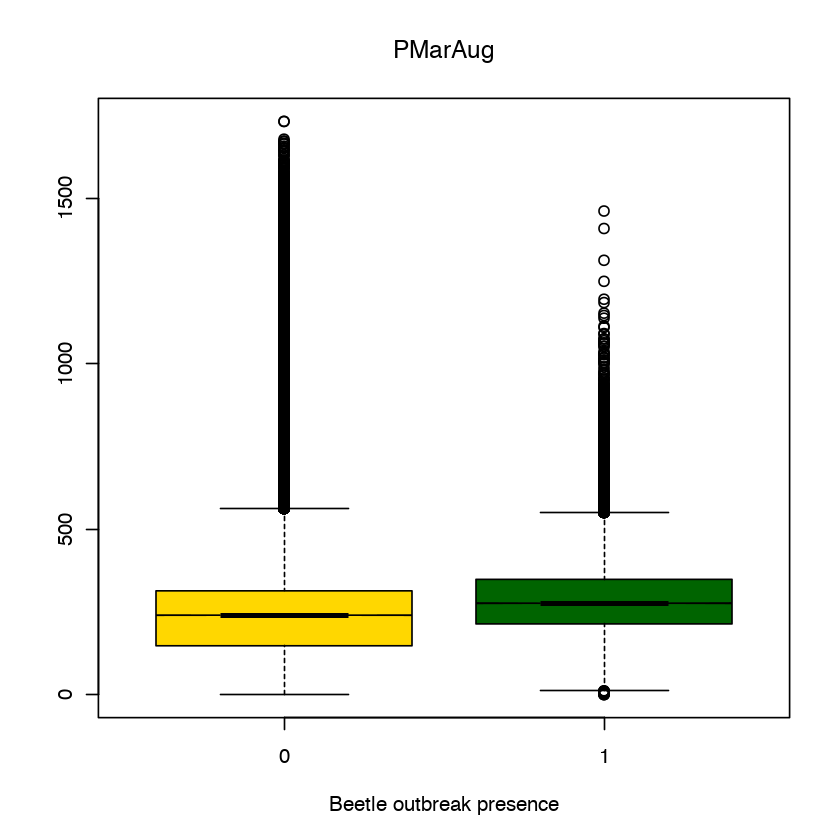

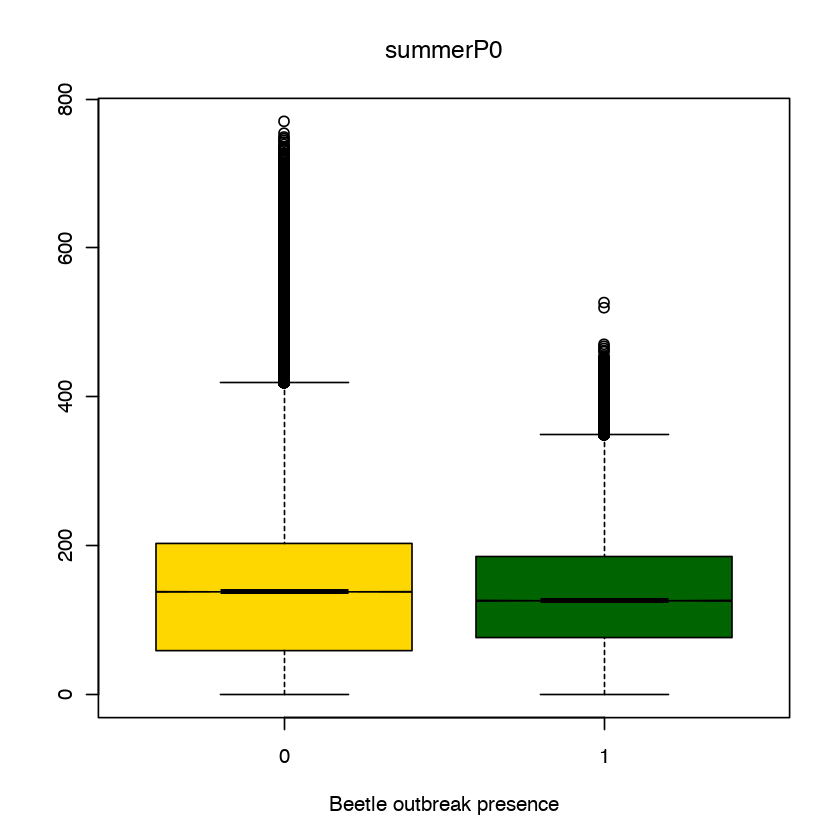

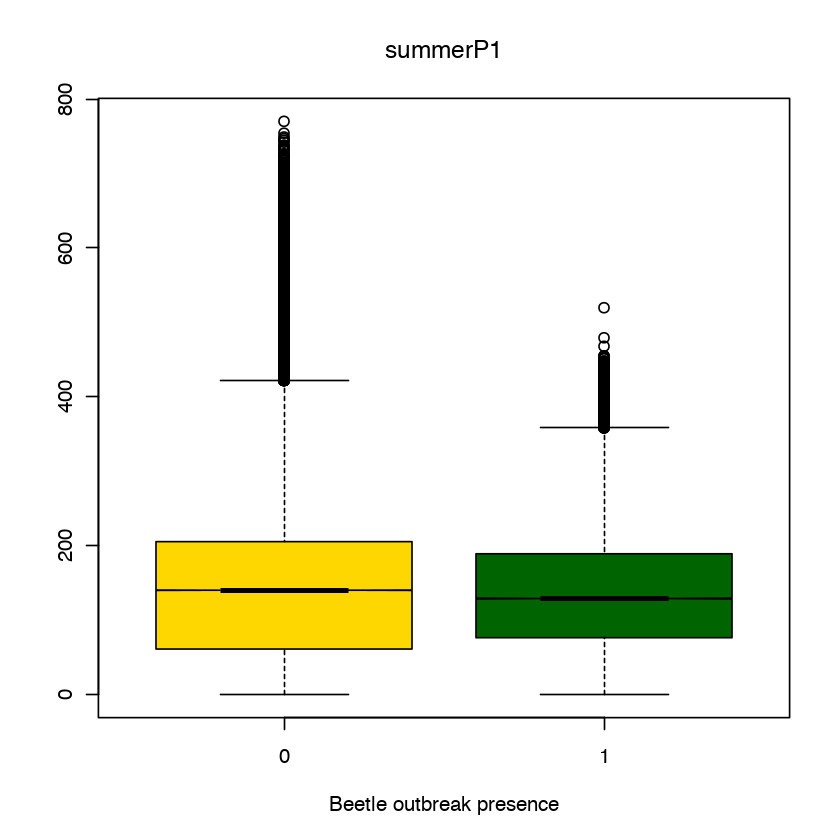

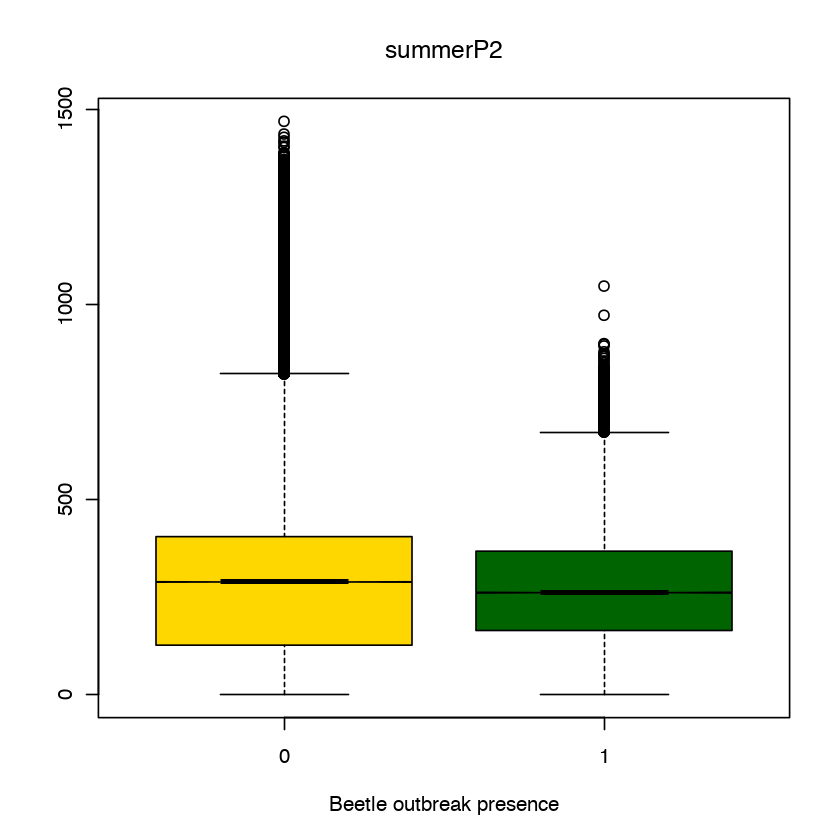

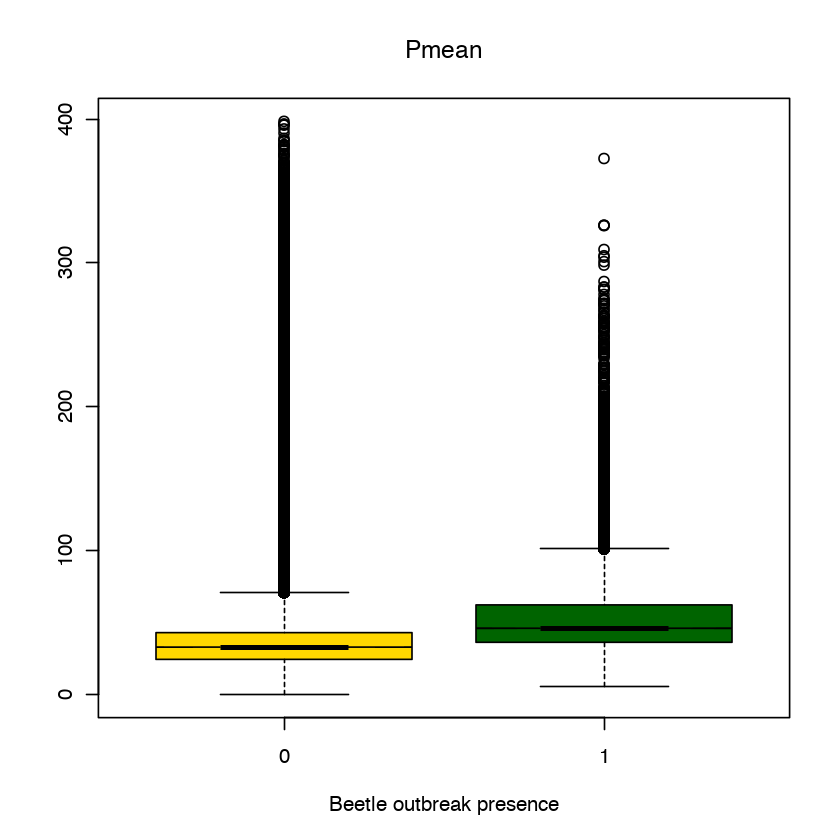

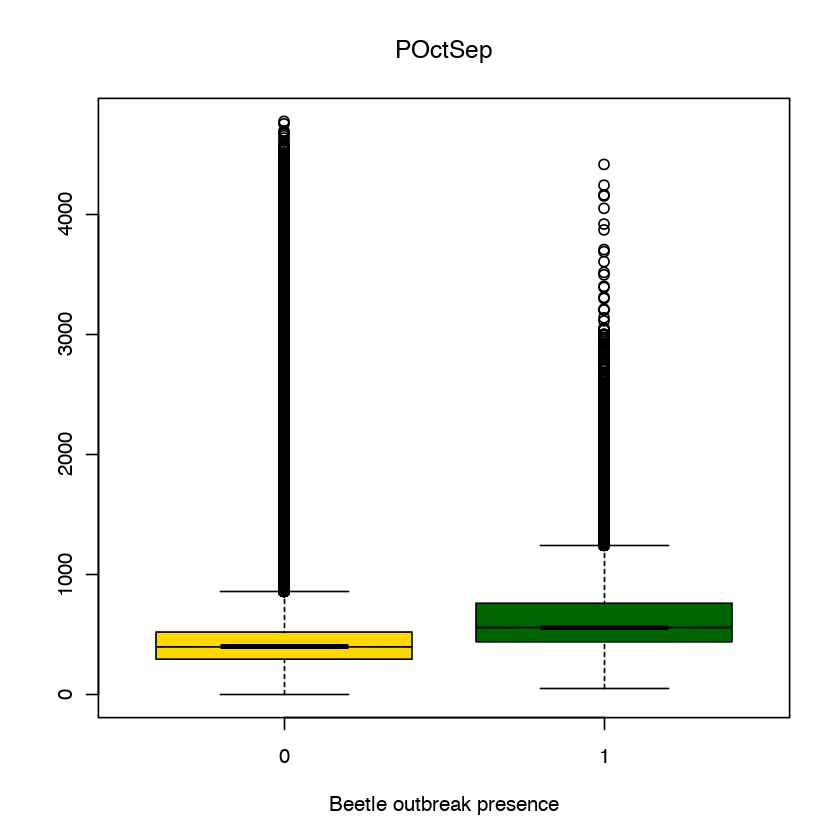

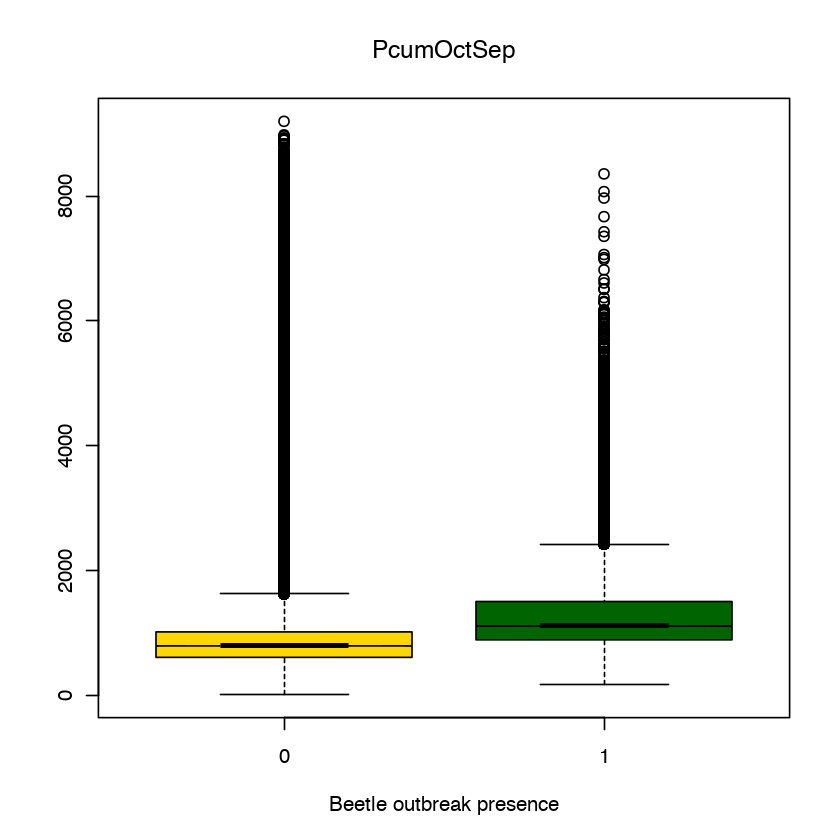

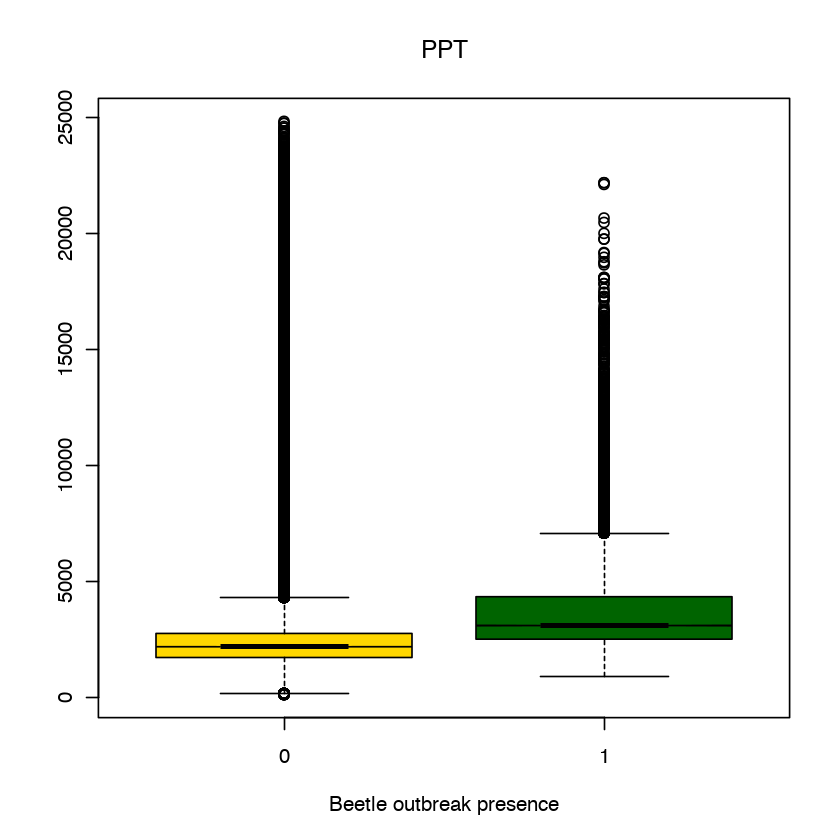

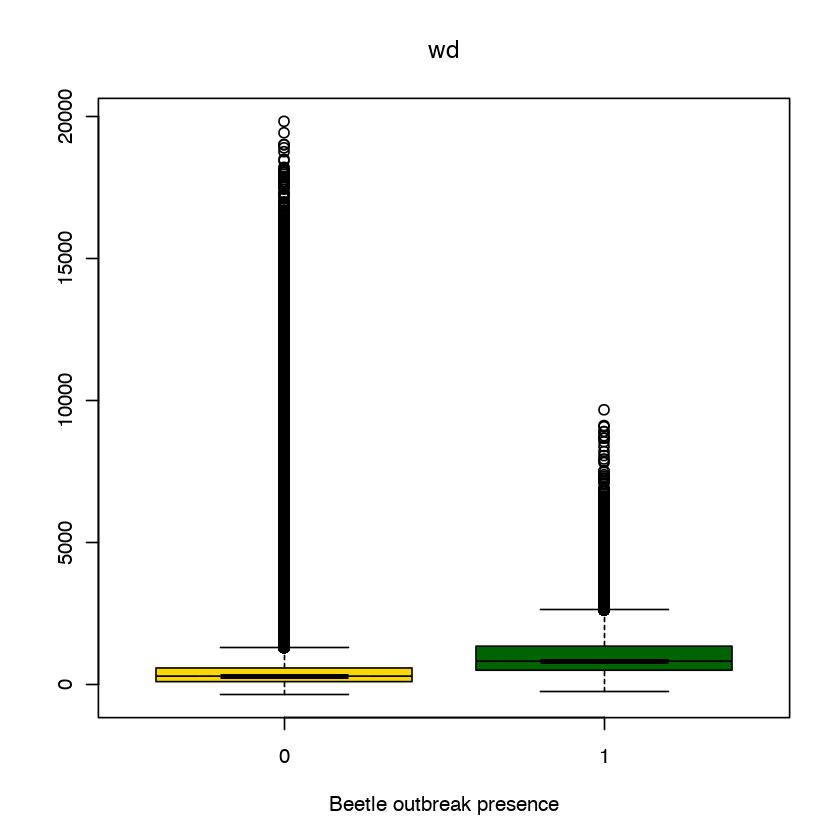

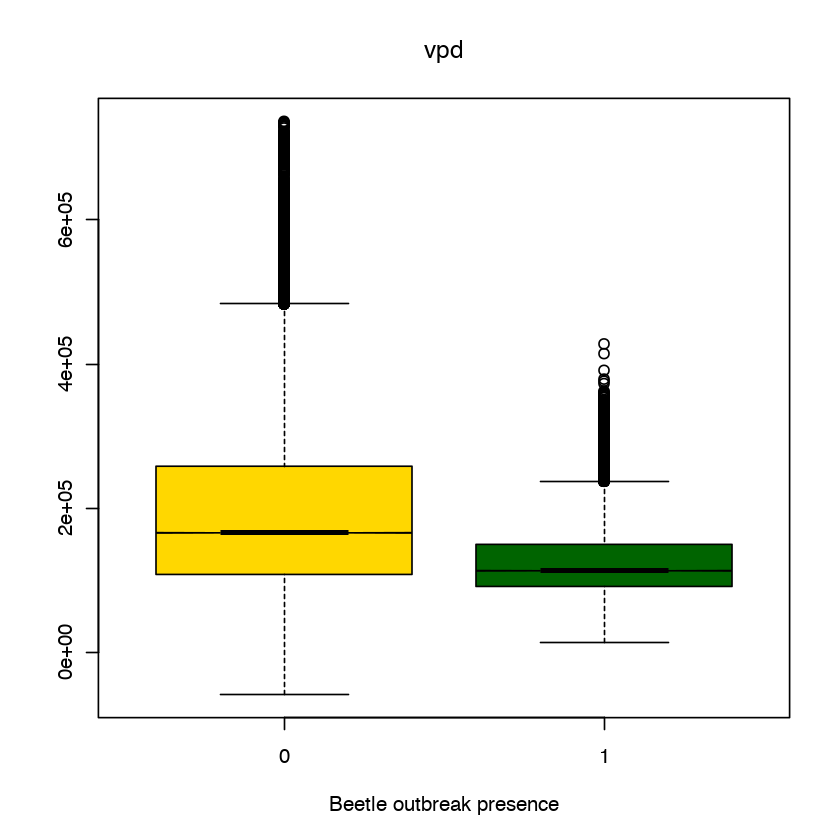

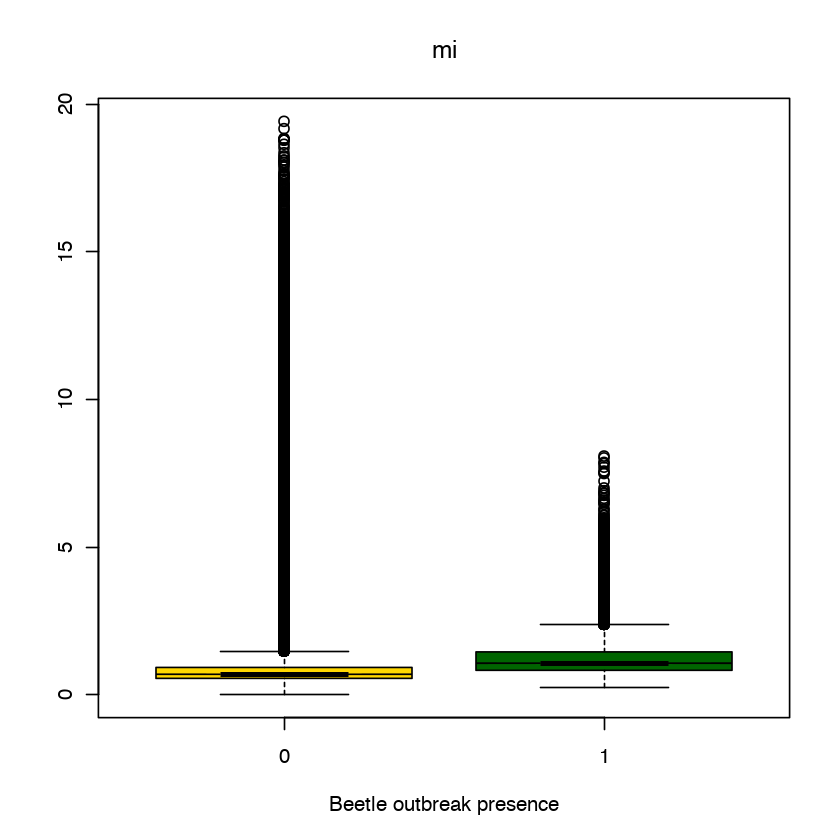

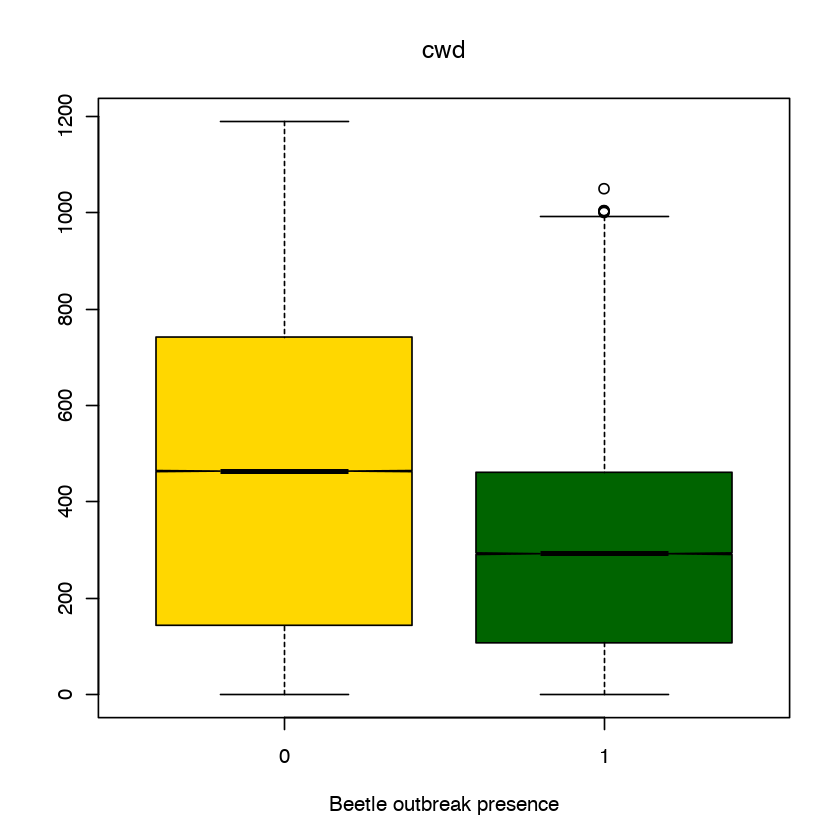

In [18]:
for(var in vars){
  boxplot(train[,var]~btl_t, data=train, notch=TRUE,
  col=(c("gold","darkgreen")),
  main=var, xlab="Beetle outbreak presence") 
}

In [20]:
rcorr(as.matrix(train[,vars])) 

            Jan20 Mar20   Acs max.drop JanTmin MarTmin OctTmin  Tmin OctMin
Jan20        1.00  0.74  0.82     0.61   -0.84   -0.73   -0.46 -0.76  -0.54
Mar20        0.74  1.00  0.66     0.45   -0.63   -0.76   -0.39 -0.67  -0.44
Acs          0.82  0.66  1.00     0.58   -0.73   -0.68   -0.45 -0.72  -0.50
max.drop     0.61  0.45  0.58     1.00   -0.69   -0.63   -0.52 -0.69  -0.59
JanTmin     -0.84 -0.63 -0.73    -0.69    1.00    0.89    0.77  0.96   0.73
MarTmin     -0.73 -0.76 -0.68    -0.63    0.89    1.00    0.83  0.96   0.75
OctTmin     -0.46 -0.39 -0.45    -0.52    0.77    0.83    1.00  0.84   0.84
Tmin        -0.76 -0.67 -0.72    -0.69    0.96    0.96    0.84  1.00   0.77
OctMin      -0.54 -0.44 -0.50    -0.59    0.73    0.75    0.84  0.77   1.00
JanMin      -0.83 -0.62 -0.72    -0.77    0.92    0.83    0.70  0.88   0.75
MarMin      -0.75 -0.77 -0.70    -0.71    0.84    0.92    0.71  0.89   0.73
winterMin   -0.77 -0.59 -0.72    -0.80    0.89    0.85    0.76  0.91   0.79
minT        

In [63]:
vif(train[,c('Acs', 'ddAugJul', 'Tvar', 'maxAugT', 'summerP0', 'wd')])

Variables,VIF
Acs,2.453081
ddAugJul,1.819478
Tvar,2.814355
maxAugT,2.193634
summerP0,1.811219
wd,2.253517


In [10]:
select <- c('Acs', 'ddAugJul', 'Tvar', 'maxAugT', 'summerP0', 'wd')

In [65]:
rcorr(as.matrix(train[,select]))

           Acs ddAugJul  Tvar maxAugT summerP0    wd
Acs       1.00    -0.43  0.70   -0.37     0.42 -0.04
ddAugJul -0.43     1.00 -0.28    0.58    -0.50 -0.38
Tvar      0.70    -0.28  1.00   -0.09     0.27 -0.37
maxAugT  -0.37     0.58 -0.09    1.00    -0.56 -0.53
summerP0  0.42    -0.50  0.27   -0.56     1.00  0.39
wd       -0.04    -0.38 -0.37   -0.53     0.39  1.00

n= 790328 


P
         Acs ddAugJul Tvar maxAugT summerP0 wd
Acs           0        0    0       0        0
ddAugJul  0            0    0       0        0
Tvar      0   0             0       0        0
maxAugT   0   0        0            0        0
summerP0  0   0        0    0                0
wd        0   0        0    0       0         

In [11]:
loc <- c('lon', 'lat', 'etopo1')
tree <- c('age', 'density')
preds <- c(select, loc, tree)

In [16]:
var.string <- function(st){
    for (p in preds) {
        cat(sprintf('+ %s(%s) ', st, p))
    } 
}

In [17]:
mod.string <- paste0('gam(btl_t ~ te(sum9_diff)', capture.output(var.string('te')),
                     ', data=train, family=binomial)')

In [ ]:
start <- Sys.time()
mod <- eval(parse(text=mod.string))
stop <- Sys.time()

In [ ]:
cat('Elapsed time:', stop - start, 's\n')

In [ ]:
par(mfrow=c(3, 3))
plot(mod)

In [ ]:
summary(mod)

In [130]:
#get the predicted probabilities for each sample
gampred <- predict(mod, type="response")

#make a ROCR prediction object using the predicted values from
#    our model and the true values from the real data
rp <- prediction(gampred, train$btl_t) 

#now calculate AUC
auc <- performance( rp, "auc")@y.values[[1]]
auc

#not plot ROC curve
roc <- performance( rp, "tpr", "fpr")
plot( roc )

In [131]:
threshold <- 0.5

In [132]:
preds <- ifelse(as.numeric(preds) > threshold, 1, 0)

In [133]:
test$error <- preds - test$btl_t

In [134]:
table(preds)

preds
    0     1 
91263  5794 

In [96]:
shppath <- "/Users/dongmeichen/Documents/beetle/shp"
canada.prov <- readOGR(dsn = shppath, layer = "na10km_can_prov")
us.states <- readOGR(dsn = shppath, layer = "na10km_us_state")
crs <- proj4string(us.states)
lrglakes <- readOGR(dsn = shppath, layer = "na10km_lrglakes")
proj4string(lrglakes) <- crs

OGR data source with driver: ESRI Shapefile 
Source: "/Users/dongmeichen/Documents/beetle/shp", layer: "na10km_can_prov"
with 13 features
It has 2 fields
OGR data source with driver: ESRI Shapefile 
Source: "/Users/dongmeichen/Documents/beetle/shp", layer: "na10km_us_state"
with 51 features
It has 2 fields
OGR data source with driver: ESRI Shapefile 
Source: "/Users/dongmeichen/Documents/beetle/shp", layer: "na10km_lrglakes"
with 24 features
It has 2 fields


In [106]:
get.spdf <- function(year){
    df <- test[test$year==year,]
    xy <- data.frame(df[,c(2,3)])
    coordinates(xy) <- c('x', 'y')
    proj4string(xy) <- crs
    spdf <- SpatialPointsDataFrame(coords = xy, data = df, proj4string = crs)
    return(spdf)
}

In [98]:
nclr <- 3
plotclr <- c('#440154','#208F8B','#FDE724')

In [135]:
probmapping_ts <- function(){
    #png("accuracy.png", width=12, height=12, units="in", res=300)
    par(mfrow=c(3,6),mar=c(0.5,0.5,1.5,0))
    for (year in 1998:2015){
        spdf <- get.spdf(year)
        plotvar <- spdf$error
        class <- classIntervals(plotvar, nclr, style="equal")
        colcode <- findColours(class, plotclr)
        plot(spdf, col=colcode, pch=15, cex=0.25)
        title(main=year, adj = 0.5, line = -1, cex.main=2)
        plot(canada.prov, col=rgb(0.7,0.7,0.7,0.7), cex=0.3, add=T)
        plot(us.states, col=rgb(0.7,0.7,0.7,0.7), cex=0.3, add=T)
        print(year)
    }
    #dev.off()
}

Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 1998


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 1999


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2000


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2001


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2002


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2003


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2004


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2005


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2006


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2007


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2008


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2009


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2010


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2011


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2012


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2013


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2014


Warning message in classIntervals(plotvar, nclr, style = "equal"):
“var has missing values, omitted in finding classes”Warning message in classIntervals(plotvar, nclr, style = "equal"):
“n same as number of different finite values\neach different finite value is a separate class”

[1] 2015


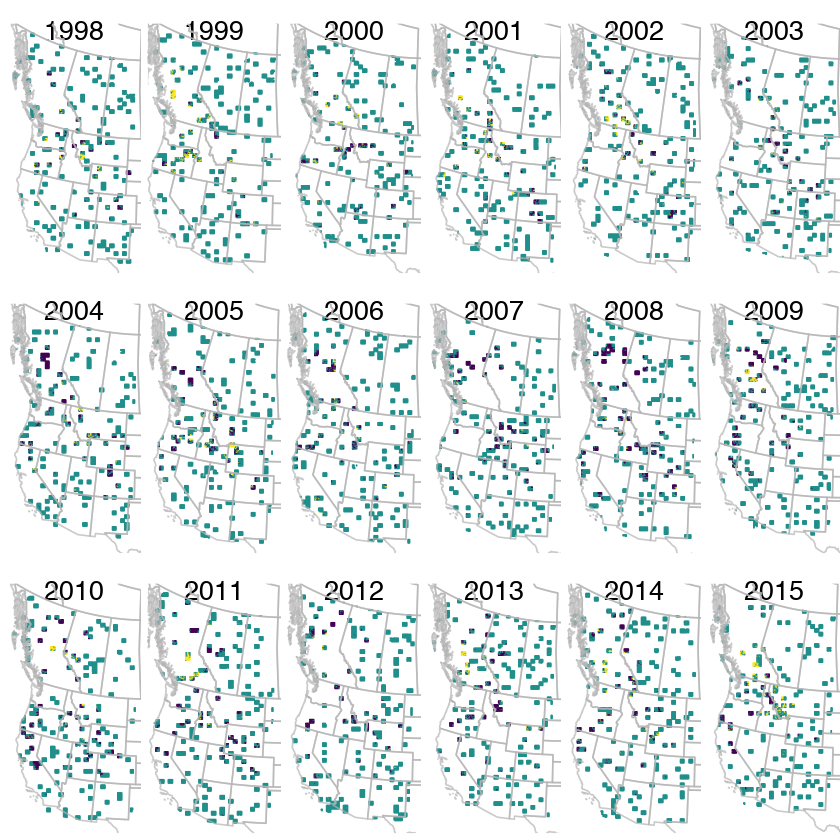

In [136]:
probmapping_ts()